Predefined functions / class

In [24]:
import os
import dill
from pathlib import Path
import argparse
import sys

sys.path.append('/scratch/connectome/ycryu/ENIGMA_OCD_MBBN/MBBN-main')

from utils import *

def setup_folders(base_path): 
    os.makedirs(os.path.join(base_path,'experiments'),exist_ok=True) 
    os.makedirs(os.path.join(base_path,'runs'),exist_ok=True)
    os.makedirs(os.path.join(base_path, 'splits'), exist_ok=True)
    return None


In [25]:
class Args:
    def __init__(self):
        self.dataset_name = 'ENIGMA_OCD'
        self.base_path = '/scratch/connectome/ycryu/ENIGMA_OCD_MBBN/MBBN-main' # YC : Should be fixed
        self.enigma_path = '/scratch/connectome/ycryu/MBBN_data_mini'
        self.step = '4' # step 4 for testing
        self.fine_tune_task = 'binary_classification'
        self.target = 'OCD'
        self.fmri_type = 'divided_timeseries'
        self.transformer_hidden_layers = 8
        self.seq_part = 'head'
        self.fmri_dividing_type = 'three_channels'
        self.spat_diff_loss_type = 'minus_log'
        self.spatial_loss_factor = 4.0
        self.exp_name = 'test_evaluation_seed101'
        self.seed = 101
        self.intermediate_vec = 316
        self.num_heads = 4
        self.fmri_dividing_type = 'three_channels'
        self.sequence_length_phase4 = 100
        self.distributed = False # True for distributed training
        self.wandb_mode = 'disabled'
        self.lr_warmup_phase4 = 1
        # self.workers_phase1 = 1
        # self.workers_phase2 = 1
        # self.workers_phase3 = 1
        self.workers_phase4 = 1

        ## YC : Should apply to new code
        self.num_forward_pass = 16

In [26]:
def get_arguments(base_path):
    parser = argparse.ArgumentParser()
    parser.add_argument('--exp_name', type=str,default="baseline") 
    parser.add_argument('--dataset_name', type=str, choices=['HCP1200', 'ABCD', 'ABIDE', 'UKB', 'ENIGMA_OCD'], default="ENIGMA_OCD")
    parser.add_argument('--fmri_type', type=str, choices=['timeseries', 'frequency', 'divided_timeseries', 'time_domain_low', 'time_domain_ultralow', 'time_domain_high', 'frequency_domain_low', 'frequency_domain_ultralow', 'frequency_domain_high'], default="divided_timeseries")
    parser.add_argument('--intermediate_vec', type=int, default=400)
    parser.add_argument('--abcd_path', default='/scratch/connectome/stellasybae/ABCD_ROI/7.ROI') ## labserver
    parser.add_argument('--ukb_path', default='/scratch/connectome/stellasybae/UKB_ROI') ## labserver
    parser.add_argument('--abide_path', default='/scratch/connectome/stellasybae/ABIDE_ROI') ## labserver
    parser.add_argument('--enigma_path', default='/pscratch/sd/p/pakmasha/MBBN_data') ## Perlmutter 
    parser.add_argument('--base_path', default=base_path) # where your main.py, train.py, model.py are in.
    parser.add_argument('--step', default='1', choices=['1','2','3','4'], help='which step you want to run') # YC : Step 1 : vanilla_BERT / Step 2 : MBBN / Step 3 : divfreqBERT_reconstruction / Step 4 : test
    
    
    parser.add_argument('--target', type=str, default='OCD')
    parser.add_argument('--fine_tune_task',
                        choices=['regression','binary_classification'],
                        help='fine tune model objective. choose binary_classification in case of a binary classification task')
    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--visualization', action='store_true')
    parser.add_argument('--prepare_visualization', action='store_true')
    parser.add_argument('--weightwatcher', action='store_true')
    parser.add_argument('--weightwatcher_save_dir', default=None)

    
    
    parser.add_argument('--norm_axis', default=1, type=int, choices=[0,1,None])
    
    parser.add_argument('--cuda', default=True)
    parser.add_argument('--log_dir', type=str, default=os.path.join(base_path, 'runs'))

    parser.add_argument('--transformer_hidden_layers', type=int,default=8)
    
    # DDP configs:
    parser.add_argument('--world_size', default=-1, type=int, 
                        help='number of nodes for distributed training')
    parser.add_argument('--rank', default=-1, type=int, 
                        help='node rank for distributed training')
    parser.add_argument('--local_rank', default=-1, type=int, 
                        help='local rank for distributed training')
    parser.add_argument('--dist_backend', default='nccl', type=str, 
                        help='distributed backend')
    parser.add_argument('--init_method', default='file', type=str, choices=['file','env'], help='DDP init method')
    parser.add_argument('--distributed', default=True)

    # AMP configs:
    parser.add_argument('--amp', action='store_false')
    parser.add_argument('--gradient_clipping', action='store_true')
    parser.add_argument('--clip_max_norm', type=float, default=1.0)
    
    # Gradient accumulation
    parser.add_argument("--accumulation_steps", default=1, type=int,required=False,help='mini batch size == accumulation_steps * args.train_batch_size')
    
    # Nsight profiling
    parser.add_argument("--profiling", action='store_true')
    
    #wandb related
    parser.add_argument('--wandb_key', default='d0330ca06936eecd637c3470c47af6d33e1cb277', type=str,  help='default: key for ycryu')
    parser.add_argument('--wandb_mode', default='online', type=str,  help='online|offline')
    parser.add_argument('--wandb_entity', default='youngchanryu-seoul-national-university', type=str)
    parser.add_argument('--wandb_project', default='enigma-ocd_mbbn', type=str)

    
    # dividing
    parser.add_argument('--filtering_type', default='Boxcar', choices=['FIR', 'Boxcar'])
    parser.add_argument('--use_high_freq', action='store_true')
    parser.add_argument('--divide_by_lorentzian', action='store_true')
    parser.add_argument('--use_raw_knee', action='store_true')
    parser.add_argument('--seq_part', type=str, default='head')
    parser.add_argument('--fmri_dividing_type', default='three_channels', choices=['two_channels', 'three_channels', 'four_channels'])
    
    # Dropouts
    parser.add_argument('--transformer_dropout_rate', type=float, default=0.3) 

    # Architecture
    parser.add_argument('--num_heads', type=int, default=12,
                        help='number of heads for BERT network (default: 12)')
    parser.add_argument('--attn_mask', action='store_false',
                        help='use attention mask for Transformer (default: true)')
                        
    
    ## for finetune
    parser.add_argument('--pretrained_model_weights_path', default=None)
    parser.add_argument('--finetune', action='store_true')
    parser.add_argument('--finetune_test', action='store_true', help='test phase of finetuning task')
    
    
    ## spatiotemporal
    parser.add_argument('--spatiotemporal', action = 'store_true')
    parser.add_argument('--spat_diff_loss_type', type=str, default='minus_log', choices=['minus_log', 'reciprocal_log', 'exp_minus', 'log_loss', 'exp_whole'])
    parser.add_argument('--spatial_loss_factor', type=float, default=0.1)
    
    ## ablation
    parser.add_argument('--ablation', type=str, choices=['convolution', 'no_high_freq'])
    
    ## YC : Phase means step
    ## phase 1 vanilla BERT
    parser.add_argument('--task_phase1', type=str, default='vanilla_BERT')
    parser.add_argument('--batch_size_phase1', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples')
    parser.add_argument('--validation_frequency_phase1', type=int, default=10000000)
    parser.add_argument('--nEpochs_phase1', type=int, default=2)  # initially, default=100
    parser.add_argument('--optim_phase1', default='AdamW')
    parser.add_argument('--weight_decay_phase1', type=float, default=1e-2)
    parser.add_argument('--lr_policy_phase1', default='SGDR', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase1', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase1', type=float, default=0.97)
    parser.add_argument('--lr_step_phase1', type=int, default=3000)
    parser.add_argument('--lr_warmup_phase1', type=int, default=500)
    parser.add_argument('--sequence_length_phase1', type=int ,default=300) # ABCD 348 ABIDE 280 UKB 464
    parser.add_argument('--workers_phase1', type=int,default=4)
    parser.add_argument('--num_heads_2DBert', type=int, default=12)
    
    ## phase 2 MBBN
    parser.add_argument('--task_phase2', type=str, default='MBBN')
    parser.add_argument('--batch_size_phase2', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples')
    parser.add_argument('--nEpochs_phase2', type=int, default=100)  # initially, default=100
    parser.add_argument('--optim_phase2', default='AdamW')
    parser.add_argument('--weight_decay_phase2', type=float, default=1e-2)
    parser.add_argument('--lr_policy_phase2', default='SGDR', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase2', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase2', type=float, default=0.97)
    parser.add_argument('--lr_step_phase2', type=int, default=3000)
    parser.add_argument('--lr_warmup_phase2', type=int, default=500)
    parser.add_argument('--sequence_length_phase2', type=int ,default=300) # ABCD 348 ABIDE 280 UKB 464
    parser.add_argument('--workers_phase2', type=int, default=4)   # default=4
    
    ##phase 3 pretraining
    parser.add_argument('--task_phase3', type=str, default='MBBN_pretraining')
    parser.add_argument('--batch_size_phase3', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples')
    parser.add_argument('--validation_frequency_phase3', type=int, default=10000000)
    parser.add_argument('--nEpochs_phase3', type=int, default=1000)
    parser.add_argument('--optim_phase3', default='AdamW')
    parser.add_argument('--weight_decay_phase3', type=float, default=1e-2)
    parser.add_argument('--lr_policy_phase3', default='SGDR', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase3', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase3', type=float, default=0.97)
    parser.add_argument('--lr_step_phase3', type=int, default=3000)
    parser.add_argument('--lr_warmup_phase3', type=int, default=500)
    parser.add_argument('--sequence_length_phase3', type=int ,default=300)
    parser.add_argument('--workers_phase3', type=int,default=4)
    parser.add_argument('--use_recon_loss', action='store_true')
    parser.add_argument('--use_mask_loss', action='store_true') 
    parser.add_argument('--use_cont_loss', action='store_true')
    parser.add_argument('--masking_rate', type=float, default=0.1)
    parser.add_argument('--masking_method', type=str, default='spatiotemporal', choices=['temporal', 'spatial', 'spatiotemporal'])
    parser.add_argument('--temporal_masking_type', type=str, default='time_window', choices=['single_point','time_window'])
    parser.add_argument('--temporal_masking_window_size', type=int, default=20)
    parser.add_argument('--window_interval_rate', type=int, default=2)
    parser.add_argument('--spatial_masking_type', type=str, default='random_ROIs', choices=['hub_ROIs', 'random_ROIs'])
    parser.add_argument('--communicability_option', type=str, default='remove_high_comm_node', choices=['remove_high_comm_node', 'remove_low_comm_node'])
    parser.add_argument('--num_hub_ROIs', type=int, default=5)
    parser.add_argument('--num_random_ROIs', type=int, default=5)
    parser.add_argument('--spatiotemporal_masking_type', type=str, default='whole', choices=['whole', 'separate'])
    
    
    ## phase 4 (test)
    parser.add_argument('--task_phase4', type=str, default='test')
    parser.add_argument('--model_weights_path_phase4', default=None)
    parser.add_argument('--batch_size_phase4', type=int, default=4)
    parser.add_argument('--nEpochs_phase4', type=int, default=1)
    parser.add_argument('--optim_phase4', default='AdamW')
    parser.add_argument('--weight_decay_phase4', type=float, default=1e-2)
    parser.add_argument('--lr_policy_phase4', default='SGDR', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase4', type=float, default=1e-4)
    parser.add_argument('--lr_gamma_phase4', type=float, default=0.9)
    parser.add_argument('--lr_step_phase4', type=int, default=3000)
    parser.add_argument('--lr_warmup_phase4', type=int, default=100)
    parser.add_argument('--sequence_length_phase4', type=int,default=300) # ABCD 348 ABIDE 280 UKB 464
    parser.add_argument('--workers_phase4', type=int, default=4)

    ## YC : Should apply to new code
    parser.add_argument('--num_forward_pass', type=int, default=16)
                        
    args = parser.parse_args()
        
    return args

In [27]:
args_instance = Args()

sys.argv = [
    'test.ipynb',
    '--dataset_name', args_instance.dataset_name,
    '--base_path', args_instance.base_path,
    '--enigma_path', args_instance.enigma_path,
    '--step', args_instance.step,
    '--fine_tune_task', args_instance.fine_tune_task,
    '--target', args_instance.target,
    '--fmri_type', args_instance.fmri_type,
    '--transformer_hidden_layers', str(args_instance.transformer_hidden_layers),
    '--divide_by_lorentzian', 
    '--seq_part', args_instance.seq_part,
    '--use_raw_knee',
    '--fmri_dividing_type', args_instance.fmri_dividing_type,
    '--use_high_freq',
    '--spatiotemporal',
    '--spat_diff_loss_type', args_instance.spat_diff_loss_type,
    '--spatial_loss_factor', str(args_instance.spatial_loss_factor),
    '--exp_name', args_instance.exp_name,
    '--seed', str(args_instance.seed),
    '--intermediate_vec', str(args_instance.intermediate_vec),
    '--num_heads', str(args_instance.num_heads),
    '--sequence_length_phase4', str(args_instance.sequence_length_phase4),
    '--distributed', str(args_instance.distributed),
    '--wandb_mode', args_instance.wandb_mode,
    '--lr_warmup_phase4', str(args_instance.lr_warmup_phase4),
    # '--workers_phase1', str(args_instance.workers_phase1),
    # '--workers_phase2', str(args_instance.workers_phase2),
    # '--workers_phase3', str(args_instance.workers_phase3),
    '--workers_phase4', str(args_instance.workers_phase4),

    ## YC : Should apply to new code
    '--num_forward_pass', str(args_instance.num_forward_pass)
]

args = get_arguments(args_instance.base_path)
print(args)

Namespace(exp_name='test_evaluation_seed101', dataset_name='ENIGMA_OCD', fmri_type='divided_timeseries', intermediate_vec=316, abcd_path='/scratch/connectome/stellasybae/ABCD_ROI/7.ROI', ukb_path='/scratch/connectome/stellasybae/UKB_ROI', abide_path='/scratch/connectome/stellasybae/ABIDE_ROI', enigma_path='/scratch/connectome/ycryu/MBBN_data_mini', base_path='/scratch/connectome/ycryu/ENIGMA_OCD_MBBN/MBBN-main', step='4', target='OCD', fine_tune_task='binary_classification', seed=101, visualization=False, prepare_visualization=False, weightwatcher=False, weightwatcher_save_dir=None, norm_axis=1, cuda=True, log_dir='/scratch/connectome/ycryu/ENIGMA_OCD_MBBN/MBBN-main/runs', transformer_hidden_layers=8, world_size=-1, rank=-1, local_rank=-1, dist_backend='nccl', init_method='file', distributed='False', amp=True, gradient_clipping=False, clip_max_norm=1.0, accumulation_steps=1, profiling=False, wandb_key='d0330ca06936eecd637c3470c47af6d33e1cb277', wandb_mode='disabled', wandb_entity='youn

In [28]:
from trainer import Trainer
from loss_writer import Writer
import matplotlib.pyplot as plt

phase_num = '4' # WHY?? Maybe just same with step
model_path = '/scratch/connectome/ycryu/ENIGMA_OCD_MBBN/MBBN-main/experiments/ENIGMA_OCD_mbbn_OCD_from_scratch_seed101_1gpu/ENIGMA_OCD_mbbn_OCD_from_scratch_seed101_1gpu_epoch_9_BEST_val_ACC.pth'

Overload methods of Writer

In [29]:
from sklearn.metrics import roc_curve

class UQWriter(Writer):
    def __init__(self, sets, val_threshold, **kwargs):
        super().__init__(sets, val_threshold, **kwargs)
        self.confidence_list = []
        self.is_correct_list = []

    # YC : This goes into metrics.py
    def compute_far95(self, pred_probs, true_labels, pos_label=1, target_recall=0.95):
        fpr, tpr, thresholds = roc_curve(true_labels, pred_probs, pos_label=pos_label)

        print(f"fpr: {fpr}")
        print(f"tpr: {tpr}")
        print(f"thresholds: {thresholds}")

        print(f"pred probs: {pred_probs}")
        print(f"true labels: {true_labels}")

        valid_indices = np.where(tpr >= target_recall)[0]

        print(f"valid_indices: {valid_indices}")

        if len(valid_indices) == 0:
            print(f"No threshold found for target recall {target_recall}")
            return None
        
        idx = valid_indices[0]
        threshold = thresholds[idx]
        far95 = fpr[idx]

        return far95, threshold


    def compute_confidence(self, confidence_list: list, is_correct_list: list):
        num_bins = 10
        bin_edges = np.linspace(0.0, 1.0, num_bins + 1)  # Bin edges from 0 to 1
        bin_indices = np.digitize(confidence_list, bin_edges, right=True)
        bin_middlepoint = (bin_edges[1:] + bin_edges[:-1])/2

        bin_confidences = []
        bin_accuracies = []
        bin_gaps = []
        confidence_nparray = np.array(confidence_list)
        is_correct_nparray = np.array(is_correct_list)
        # ECE is weighted average of calibration error in each bin
        # MCE is maximum calibration error in each bin
        cum_ce = 0
        mce = 0

        # organizing bin elements
        for i in range(1, num_bins + 1):
            indices = np.where(bin_indices == i)[0]  # Get indices of elements in the bin
            if len(indices) > 0:
                avg_confidence = np.mean(confidence_nparray[indices])  # Average confidence
                avg_accuracy = np.mean(is_correct_nparray[indices])  # Accuracy as mean of correct labels
                gap = avg_confidence - avg_accuracy  # Gap between confidence and accuracy

                bin_confidences.append(avg_confidence)
                bin_accuracies.append(avg_accuracy)
                bin_gaps.append(gap)
                cum_ce += np.abs(gap) * len(indices)
                mce = max(mce, np.abs(gap))
            else:
                bin_confidences.append(0)
                bin_accuracies.append(0)
                bin_gaps.append(0)
        
        ece = cum_ce / len(confidence_list)

        # ECE/MCE statistics
        print("==========All samples evaluated==========")
        print(f"\nExpected Calibration Error: {ece}")
        print(f"Maximum Calibration Error: {mce}")

        # FAR95 statistics
        far95, threshold = self.compute_far95(confidence_list, is_correct_list)
        if far95 is not None:
            print(f"\nFalse Acceptance Rate at 95% Recall: {far95} (threshold: {threshold})")

        stat_save_path = os.path.join(self.kwargs.get("experiment_folder"), 'statistics.txt')
        with open(stat_save_path, 'w') as f:
            f.write("==========All samples evaluated==========\n")
            f.write(f"Expected Calibration Error: {ece}\n")
            f.write(f"Maximum Calibration Error: {mce}\n")
            if far95 is not None:
                f.write(f"False Acceptance Rate at 95% Recall: {far95} (threshold: {threshold})\n")

        # drawing plot
        bar_width = 0.08  # Width of the bars
        plt.figure(figsize=(8, 6))

        plt.bar(bin_edges[:-1], bin_accuracies, width=bar_width, align='edge', color='blue', edgecolor='black', label="Outputs")
        plt.bar(bin_edges[:-1], bin_gaps, width=bar_width, align='edge', color='pink', alpha=0.7, label="Gap", bottom=bin_accuracies)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")

        plt.text(0.7, 0.1, f'ECE={ece:.4f}', fontsize=14, bbox=dict(facecolor='lightgray', alpha=0.5))

        plt.xlabel('Confidence')
        plt.ylabel('Accuracy')
        plt.title('Reliability Diagram')
        plt.legend()
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])

        diagram_save_path = os.path.join(self.kwargs.get("experiment_folder"), 'reliability_diagram.png')
        plt.savefig(diagram_save_path, dpi=300, bbox_inches='tight')

    def uncertainty_statistics_one_sample(self, subj_dict: dict, subj_truth: int):
    ## YC
        print("########")
        sample_prediction = 1 if subj_dict['score'].mean().item() > 0.5 else 0
        print(f"subj_truth: {subj_truth}, sample_prediction: {sample_prediction}")
        is_correct = 1 if subj_truth == sample_prediction else 0
        print(f"is_correct: {is_correct}")

        # UQ code from YC
        # if sample_prediction == 1 then use the probabilities of class 1 (which is directly from the sigmoid function)
        # and if sample_prediction == 0 then use the probabilities of class 0 (which is 1 - probabilities of class 1)
        # sample_pred_probabilities_list : list of probabilities of the class that the sample is predicted to be

        if sample_prediction == 1:
            sample_pred_probabilities_list = subj_dict['score'].tolist()
            
        else:
            sample_pred_probabilities_list = (1 - subj_dict['score']).tolist()
        
        # Calculate uncertainty
        mean = torch.mean(torch.tensor(sample_pred_probabilities_list), axis=0)
        variance = torch.var(torch.tensor(sample_pred_probabilities_list), axis=0)
        ci_95 = 1.96 * torch.sqrt(variance / len(sample_pred_probabilities_list))

        confidence_level = 0.95
        lower_percentile = (1 - confidence_level) / 2 * 100  # 2.5% for 95% CI
        upper_percentile = (1 + confidence_level) / 2 * 100  # 97.5% for 95% CI

        # Compute confidence intervals for each class
        probabilities_list = torch.stack([(1 - subj_dict['score']), subj_dict['score']], dim=1)
        print(f"probabilities_list: {probabilities_list}")
        print(f"probabilities: {torch.mean(probabilities_list, axis=0)}")
        confidence_intervals = np.percentile(probabilities_list, [lower_percentile, upper_percentile], axis=0)

        print(f"\nStatistics for sample")
        print(f"Final prediction: {sample_prediction}")
        print(f"True label: {subj_truth}")
        print(f"Correct: {True if is_correct else False}")
        print(f"Prediction probability: {mean}")
        print(f"Each stochastic passes..")
        print(f"Mean: {mean}")
        print(f"Variance: {variance}")
        print(f"95% Confidence Interval: ({mean - ci_95}, {mean + ci_95})")
        # Print the results
        for i in range(2):
            print(f"Class {i}: 95% CI = [{confidence_intervals[0, i]}, {confidence_intervals[1, i]}]")

        print("########")

        return mean, is_correct
        ## /YC

    
    def accuracy_summary(self, mid_epoch, mean, std):
        pred_all_sets = {x:[] for x in self.sets}   # dictionary to store predictions
        truth_all_sets = {x:[] for x in self.sets}  # dictionary to store ground truth values
        std_all_sets = {x:[] for x in self.sets}  # dictionary to store prediction errors
        metrics = {}
        confidence_list = []
        is_correct_list = []
        
        for subj_name,subj_dict in self.subject_accuracy.items():  # per-subject prediction scores (score), ground truth labels (truth), and the set (mode) they belong to
            
            if self.fine_tune_task == 'binary_classification':
                """
                subj_dict['score'] : logits tensor(16)
                -> do sigmoid to get probabilities
                # subj_dict['score'] = torch.sigmoid(subj_dict['score'].float())

                subj_dict['truth'] : answer tensor(1)

                # subj_pred = subj_dict['score'].mean().item() 
                # subj_error = subj_dict['score'].std().item()
                # subj_truth = subj_dict['truth'].item()
                # subj_mode = subj_dict['mode'] # train, val, test

                pred_all_sets : dictionary
                    {'test': [list of predictions], ...}
                
                """
                ### DEBUG STATEMENT ###
                print(f"scores before sigmoid: {subj_dict['score'].float()}")
                #######################
                
                subj_dict['score'] = torch.sigmoid(subj_dict['score'].float())
                
                ### DEBUG STATEMENT ###
                print(f"scores after sigmoid: {subj_dict['score']}")
                #######################


            # subj_dict['score'] denotes the logits for sequences for a subject
            subj_pred = subj_dict['score'].mean().item() 
            subj_error = subj_dict['score'].std().item()

            subj_truth = subj_dict['truth'].item()
            subj_mode = subj_dict['mode'] # train, val, test

            conf, is_corr = self.uncertainty_statistics_one_sample(subj_dict, subj_truth)
            confidence_list.append(conf)
            is_correct_list.append(is_corr)
            
            ### DEBUG STATEMENT ###
            print(f"subj_dict['score']: {subj_dict['score']}")
            print(f"subj_dict['truth']: {subj_dict['truth']}")
            #######################

            with open(os.path.join(self.per_subject_predictions,'iter_{}.txt'.format(self.eval_iter)),'a+') as f:
                f.write('subject:{} ({})\noutputs: {:.4f}\u00B1{:.4f}  -  truth: {}\n'.format(subj_name,subj_mode,subj_pred,subj_error,subj_truth))
            pred_all_sets[subj_mode].append(subj_pred) # don't use std in computing AUROC, ACC
            std_all_sets[subj_mode].append(subj_error)
            truth_all_sets[subj_mode].append(subj_truth)
            
            ### DEBUG STATEMENT ###
            print(f"pred_all_sets AFTER adding {subj_name}, subj_mode = {subj_mode}: {pred_all_sets}")
            print(f"std_all_sets AFTER adding {subj_name}, subj_mode = {subj_mode}: {std_all_sets}")
            print(f"truth_all_sets AFTER adding {subj_name}, subj_mode = {subj_mode}: {truth_all_sets}")
            #######################
            

        for (name,pred),(_, std),(_,truth) in zip(pred_all_sets.items(), std_all_sets.items(), truth_all_sets.items()):
            if len(pred) == 0:
                continue
            
            ### DEBUG STATEMENT ###
            print(f"pred:")
            print(f"    mean: {pred}")
            print(f"    std: {std}")
            print(f"truth: {truth}")
            #######################
            
            if self.fine_tune_task == 'regression':
                ## return to original scale ##
                unnormalized_pred = [i * std + mean for i in pred]
                unnormalized_truth = [i * std + mean for i in truth]

                metrics[name + '_MAE'] = self.metrics.MAE(unnormalized_truth,unnormalized_pred)
                metrics[name + '_MSE'] = self.metrics.MSE(unnormalized_truth,unnormalized_pred)
                metrics[name +'_NMSE'] = self.metrics.NMSE(unnormalized_truth,unnormalized_pred)
                metrics[name + '_R2_score'] = self.metrics.R2_score(unnormalized_truth,unnormalized_pred)
                
            else:
                metrics[name + '_Balanced_Accuracy'] = self.metrics.BAC(truth,[x>0.5 for x in torch.Tensor(pred)])
                metrics[name + '_Regular_Accuracy'] = self.metrics.RAC(truth,[x>0.5 for x in torch.Tensor(pred)]) # Stella modified it
                                
                ### DEBUG STATEMENT ###
                print(f"Truth labels (y_true): {truth}")
                print(f"Predicted scores (y_pred): {pred}")
                print(f"Predicted classes: {[1 if p > 0.5 else 0 for p in pred]}")
                print(f"Unique labels in y_true: {set(truth)}")
                if len(truth) != len(pred):
                    print(f"Length mismatch! y_true: {len(truth)}, y_pred: {len(pred)}")
                if len(set(truth)) < 2:
                    print("Skipping AUROC calculation. Only one class present in y_true.")
                    return None
                print(f"self.val_threshold: {self.val_threshold}")
                #######################
                
                metrics[name + '_AUROC'] = self.metrics.AUROC(truth,pred)             
                metrics[name +'_best_bal_acc'], metrics[name + '_best_threshold'],metrics[name + '_gmean'],metrics[name + '_specificity'],metrics[name + '_sensitivity'],metrics[name + '_f1_score'] = self.metrics.ROC_CURVE(truth,pred,name,self.val_threshold)

                ##### DEBUG STATEMENT #####
                print(f"self.val_threshold: {self.val_threshold}")
                ###########################
            self.current_metrics = metrics
            
            
        for name,value in metrics.items():
            self.scalar_to_tensorboard(name,value)
            if hasattr(self,name):
                l = getattr(self,name)
                l.append(value)
                setattr(self,name,l)
            else:
                setattr(self, name, [value])
            print('{}: {}'.format(name,value))
        self.eval_iter += 1
        if mid_epoch and len(self.subject_accuracy) > 0:
            self.subject_accuracy = {k: v for k, v in self.subject_accuracy.items() if v['mode'] == 'train'}
        else:
            self.subject_accuracy = {}

        self.confidence_list = confidence_list
        self.is_correct_list = is_correct_list

Overload methods of Trainer

In [30]:
from tqdm import tqdm
from torch.cuda.amp import autocast
from torch.utils.data import Subset, DataLoader
from torch import nn

class UQTrainer(Trainer):
    def __init__(self, sets, **kwargs):
        super().__init__(sets, **kwargs)
        self.writer = UQWriter(sets, self.val_threshold, **kwargs)
    
    def eval(self,set):
        ## If set == 'UQ-mcdropout', then set dropout to True
        if set not in ['UQ-mcdropout', 'train', 'val', 'test']:
            raise ValueError(f"Invalid set: {set}")
        self.mode = set
        if set == 'UQ-mcdropout':
            for layer in self.model.modules():
                if isinstance(layer, nn.Dropout):
                    print(f"Enabling MC Dropout for layer {layer} - p={layer.p}")
                    layer.train()
        else:
            self.model = self.model.eval()

    def finish_eval(self, set):
        if set not in ['UQ-mcdropout', 'train', 'val', 'test']:
            raise ValueError(f"Invalid set: {set}")
        if set == 'UQ-mcdropout':
            self.model = self.model.eval()

    def eval_epoch(self,set):  # evaluates the model for a single epoch
        loader = self.test_loader
        # subset_indices = [0] * 16 + [10] * 16 # YC : get indices from input
        # YC : Should be added to new code
        subset_indices = list(range(len(self.test_loader.dataset))) * self.num_forward_pass
        subset = Subset(self.test_loader.dataset, subset_indices)
        loader = DataLoader(subset, batch_size=8, shuffle=False, num_workers=0)
        print(f"len(loader): {len(loader)}")
        subject_names = [data['subject_name'] for data in loader.dataset]
        print(f"subject_names: {subject_names}")
        self.eval(set)
        inputs = []
        outputs = []
        with torch.no_grad():
            for batch_idx, input_dict in enumerate(tqdm(loader, position=0, leave=True)):
                # print("1")
                # print(input_dict)
                ### DEBUG STATEMENT ###
                # Debug: Check class distribution in each batch
                y_true = input_dict[self.target].tolist()  # Replace 'target' with the correct key for labels in input_dict
                print(f"Batch {batch_idx + 1}/{len(loader)} class distribution: {dict(zip(*np.unique(y_true, return_counts=True)))}")
                #######################
                
                with autocast():
                    input_dict, output_dict = self.forward_pass(input_dict)
                    inputs.append(input_dict)
                    outputs.append(output_dict)
        #         self.writer.write_losses(loss_dict, set=set)
        #         if self.profiling == True:
        #             if batch_idx == 10 : 
        #                 break    
        self.finish_eval(set)
        return inputs, outputs

    def testing(self):  # manages the testing phase of the model
        # options = ['UQ-mcdropout']
        inputs, outputs = self.eval_epoch('UQ-mcdropout')
        return inputs, outputs
        # self.writer.loss_summary(lr=0)
        # if self.fine_tune_task == 'regression':
        #     self.writer.accuracy_summary(mid_epoch=False, mean=self.mean, std=self.std)
        # else:
        #     self.writer.accuracy_summary(mid_epoch=False, mean=None, std=None)
        # for metric_name in dir(self.writer):
        #     if 'history' not in metric_name:
        #         continue
        #     metric_score = getattr(self.writer, metric_name)

    def forward_pass(self,input_dict): 
        
        ### DEBUG STATEMENT ###
        # print(f"forward_pass self.gpu: {self.gpu}")
        # print(f"forward_pass self.device: {self.device}")
        # print(f"forward_pass self.cuda: {self.cuda}")
        #######################
        
        #input_dict = {k:(v.to(self.gpu) if (self.cuda and torch.is_tensor(v)) else v) for k,v in input_dict.items()}
        # input_dict = {k:(v.to(self.device) if (self.cuda and torch.is_tensor(v)) else v) for k,v in input_dict.items()}
        # print("2")
        # print(input_dict)
        ### DEBUT STATEMENT ###
        input_dict = {
            k: (
                v.to(self.device) if (self.cuda and torch.is_tensor(v)) else v
            ) for k, v in input_dict.items()
        }
        for k, v in input_dict.items():
            if torch.is_tensor(v):
                # print(f"Key: {k}, Shape: {v.shape}, Device: {v.device}, Memory: {v.element_size() * v.nelement()} bytes")
                if not v.is_contiguous():
                    v = v.contiguous()
        # print("Running forward pass")
        # print(f"Model device: {next(self.model.parameters()).device}")
        #######################
        # print("3")
        # print(input_dict)
        ###### test ######
        if self.task.lower() == 'test':
            if self.fmri_type in ['timeseries', 'frequency', 'time_domain_high', 'time_domain_low', 'time_domain_ultralow', 'frequency_domain_low', 'frequency_domain_ultralow', 'frequency_domain_high']:
                output_dict = self.model(input_dict['fmri_sequence'])
            elif self.fmri_type == 'divided_timeseries':
                if self.fmri_dividing_type == 'two_channels':
                    output_dict = self.model(input_dict['fmri_lowfreq_sequence'], input_dict['fmri_ultralowfreq_sequence'])
                elif self.fmri_dividing_type == 'three_channels':
                    output_dict = self.model(input_dict['fmri_highfreq_sequence'], input_dict['fmri_lowfreq_sequence'], input_dict['fmri_ultralowfreq_sequence'])
                elif self.fmri_dividing_type == 'four_channels':
                    output_dict = self.model(input_dict['fmri_imf1_sequence'], input_dict['fmri_imf2_sequence'], input_dict['fmri_imf3_sequence'], input_dict['fmri_imf4_sequence'])

        
        #### train & valid ####
        else:
            if self.fmri_type in ['timeseries', 'frequency', 'time_domain_high', 'time_domain_low', 'time_domain_ultralow', 'frequency_domain_low', 'frequency_domain_ultralow', 'frequency_domain_high']:
                output_dict = self.model(input_dict['fmri_sequence'])
                # print(f"self.fmri_type: {self.fmri_type}, output_dict.keys: {output_dict.keys()}")
            elif self.fmri_type == 'divided_timeseries':
                if self.fmri_dividing_type == 'two_channels':
                    output_dict = self.model(input_dict['fmri_lowfreq_sequence'], input_dict['fmri_ultralowfreq_sequence'])
                elif self.fmri_dividing_type == 'three_channels':
                    output_dict = self.model(input_dict['fmri_highfreq_sequence'], input_dict['fmri_lowfreq_sequence'], input_dict['fmri_ultralowfreq_sequence'])
                elif self.fmri_dividing_type == 'four_channels':
                    output_dict = self.model(input_dict['fmri_imf1_sequence'], input_dict['fmri_imf2_sequence'], input_dict['fmri_imf3_sequence'], input_dict['fmri_imf4_sequence'])
                    
                    ### DEBUG STATEMENT ###
                    torch.cuda.synchronize()
                    #######################
                                
        # print(f"output_dict: {output_dict}")
        return input_dict, output_dict
    
        # torch.cuda.nvtx.range_push("aggregate_losses")
        # loss_dict, loss = self.aggregate_losses(input_dict, output_dict)
        
        # torch.cuda.nvtx.range_pop()
        # if self.task.lower() in ['vanilla_bert', 'mbbn', 'mbbn_pretraining', 'test']:
        #     if self.target != 'reconstruction':
        #         self.compute_accuracy(input_dict, output_dict)
                
        # return loss_dict, loss
        

Start test code

In [31]:
base_path = os.getcwd() 
setup_folders(base_path) 
args = get_arguments(base_path)

# DDP initialization
init_distributed(args)

# load weights that you specified at the Argument
model_weights_path, step, task = weight_loader(args)
model_weights_path = model_path

In [32]:
experiment_folder = '{}_{}_{}_{}'.format(args.dataset_name, 'test_{}'.format(args.fine_tune_task), args.exp_name, datestamp())
# YC : Datestamp should be deleted at real application
experiment_folder = Path(os.path.join(args.base_path,'tests', experiment_folder))
os.makedirs(experiment_folder,exist_ok=True)
setattr(args,'loaded_model_weights_path_phase' + phase_num, model_weights_path)

In [33]:
args.experiment_folder = experiment_folder
args.experiment_title = experiment_folder.name
args_logger(args)
args = sort_args(args.step, vars(args))
S = ['UQ-mcdropout', 'ensemble']

In [34]:
uq_trainer = UQTrainer(sets=S,**args)
# uq_trainer.testing()

Error processing subject Seoul-SNU_sub-NOR68SDS: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-UMO27LCY: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-NOR55JJU: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-UMO05HSH: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-NOR68SDS: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-UMO27LCY: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-NOR55JJU: operands could not be broadcast together with shapes (100,) (92,) (100,) 
Error processing subject Seoul-SNU_sub-UMO05HSH: operands could not be broadcast together with shapes (100,) (92,) (100,) 
/scratch/connect

Debugging...
AttributeError: 'Trainer' object has no attribute 'gpu'

It was because init_distributed(args) has not executed

In [35]:
inputs, outputs = uq_trainer.testing()

len(loader): 46
subject_names: ['NYSPI-Columbia-Adults_sub-simpaocd597000', 'Chiba-CHBSRPB_sub-SUA015', 'Yale-Pittinger-Yale-2014_sub-Yale2014AdultOCDtr8119', 'Bangalore-NIMHANS_sub-C0224', 'Yale-Pittinger-HCP-Trio_sub-YaleHCPTriopb2759', 'Chiba-CHBSRPB_sub-MADHC042', 'Barcelone-Bellvitge-ANTIGA-1.5T_sub-subIDIBELL15C030', 'Yale-Pittinger-HCP-Prisma_sub-YaleHCPPrismapb3318', 'Dresden_sub-GEROME3027', 'Brazil_sub-P00309620161127', 'Chiba-CHBC_sub-HCC017', 'Braga-UMinho-Braga-1.5T_sub-MRI201507152OCD082', 'Yale-Pittinger-HCP-Prisma_sub-YaleHCPPrismapb4591', 'Dresden_sub-GEROME3043', 'Braga-UMinho-Braga-1.5T_sub-MRI201508212OCD093', 'Braga-UMinho-Braga-3T_sub-MRI201909031BART028', 'New-York_sub-subSEQ1NKISENR139', 'Chiba-CHBC_sub-HCC027', 'Chiba-CHBC_sub-HCC012', 'Yale-Gruner_sub-S2271VJF', 'Kyoto-KPU-Kyoto1.5T_sub-subKyoto15Tsubj0111', 'Cape-Town-UCT-Skyra_sub-ESCO66', 'Kyoto-KPU-Kyoto1.5T_sub-subKyoto15Tsubj0124', 'NYSPI-Columbia-Adults_sub-simpaocd597000', 'Chiba-CHBSRPB_sub-SUA015', '

  2%|▏         | 1/46 [00:00<00:14,  3.12it/s]

Batch 1/46 class distribution: {0.0: 7, 1.0: 1}


  4%|▍         | 2/46 [00:00<00:14,  3.09it/s]

Batch 2/46 class distribution: {0.0: 1, 1.0: 7}


  7%|▋         | 3/46 [00:00<00:13,  3.08it/s]

Batch 3/46 class distribution: {0.0: 3, 1.0: 5}


  9%|▊         | 4/46 [00:01<00:14,  2.97it/s]

Batch 4/46 class distribution: {0.0: 6, 1.0: 2}


 11%|█         | 5/46 [00:01<00:13,  3.04it/s]

Batch 5/46 class distribution: {0.0: 1, 1.0: 7}


 13%|█▎        | 6/46 [00:01<00:13,  3.07it/s]

Batch 6/46 class distribution: {0.0: 4, 1.0: 4}


 15%|█▌        | 7/46 [00:02<00:12,  3.14it/s]

Batch 7/46 class distribution: {0.0: 5, 1.0: 3}


 17%|█▋        | 8/46 [00:02<00:12,  3.16it/s]

Batch 8/46 class distribution: {0.0: 2, 1.0: 6}


 20%|█▉        | 9/46 [00:02<00:11,  3.16it/s]

Batch 9/46 class distribution: {0.0: 4, 1.0: 4}


 22%|██▏       | 10/46 [00:03<00:11,  3.20it/s]

Batch 10/46 class distribution: {0.0: 5, 1.0: 3}


 24%|██▍       | 11/46 [00:03<00:10,  3.18it/s]

Batch 11/46 class distribution: {0.0: 2, 1.0: 6}


 26%|██▌       | 12/46 [00:03<00:10,  3.19it/s]

Batch 12/46 class distribution: {0.0: 4, 1.0: 4}


 28%|██▊       | 13/46 [00:04<00:10,  3.16it/s]

Batch 13/46 class distribution: {0.0: 4, 1.0: 4}


 30%|███       | 14/46 [00:04<00:10,  3.15it/s]

Batch 14/46 class distribution: {0.0: 2, 1.0: 6}


 33%|███▎      | 15/46 [00:04<00:09,  3.15it/s]

Batch 15/46 class distribution: {0.0: 5, 1.0: 3}


 35%|███▍      | 16/46 [00:05<00:09,  3.16it/s]

Batch 16/46 class distribution: {0.0: 3, 1.0: 5}


 37%|███▋      | 17/46 [00:05<00:09,  3.15it/s]

Batch 17/46 class distribution: {0.0: 2, 1.0: 6}


 39%|███▉      | 18/46 [00:05<00:08,  3.19it/s]

Batch 18/46 class distribution: {0.0: 6, 1.0: 2}


 41%|████▏     | 19/46 [00:06<00:08,  3.15it/s]

Batch 19/46 class distribution: {0.0: 2, 1.0: 6}


 43%|████▎     | 20/46 [00:06<00:08,  3.17it/s]

Batch 20/46 class distribution: {0.0: 2, 1.0: 6}


 46%|████▌     | 21/46 [00:06<00:07,  3.20it/s]

Batch 21/46 class distribution: {0.0: 7, 1.0: 1}


 48%|████▊     | 22/46 [00:06<00:07,  3.17it/s]

Batch 22/46 class distribution: {0.0: 1, 1.0: 7}


 50%|█████     | 23/46 [00:07<00:07,  3.16it/s]

Batch 23/46 class distribution: {0.0: 2, 1.0: 6}


 52%|█████▏    | 24/46 [00:07<00:06,  3.18it/s]

Batch 24/46 class distribution: {0.0: 7, 1.0: 1}


 54%|█████▍    | 25/46 [00:07<00:06,  3.16it/s]

Batch 25/46 class distribution: {0.0: 1, 1.0: 7}


 57%|█████▋    | 26/46 [00:08<00:06,  3.10it/s]

Batch 26/46 class distribution: {0.0: 3, 1.0: 5}


 59%|█████▊    | 27/46 [00:08<00:06,  3.02it/s]

Batch 27/46 class distribution: {0.0: 6, 1.0: 2}


 61%|██████    | 28/46 [00:08<00:05,  3.03it/s]

Batch 28/46 class distribution: {0.0: 1, 1.0: 7}


 63%|██████▎   | 29/46 [00:09<00:05,  3.03it/s]

Batch 29/46 class distribution: {0.0: 4, 1.0: 4}


 65%|██████▌   | 30/46 [00:09<00:05,  2.94it/s]

Batch 30/46 class distribution: {0.0: 5, 1.0: 3}


 67%|██████▋   | 31/46 [00:10<00:05,  2.88it/s]

Batch 31/46 class distribution: {0.0: 2, 1.0: 6}


 70%|██████▉   | 32/46 [00:10<00:04,  2.93it/s]

Batch 32/46 class distribution: {0.0: 4, 1.0: 4}


 72%|███████▏  | 33/46 [00:10<00:04,  2.93it/s]

Batch 33/46 class distribution: {0.0: 5, 1.0: 3}


 74%|███████▍  | 34/46 [00:11<00:04,  2.96it/s]

Batch 34/46 class distribution: {0.0: 2, 1.0: 6}


 76%|███████▌  | 35/46 [00:11<00:03,  3.01it/s]

Batch 35/46 class distribution: {0.0: 4, 1.0: 4}


 78%|███████▊  | 36/46 [00:11<00:03,  3.05it/s]

Batch 36/46 class distribution: {0.0: 4, 1.0: 4}


 80%|████████  | 37/46 [00:11<00:02,  3.04it/s]

Batch 37/46 class distribution: {0.0: 2, 1.0: 6}


 83%|████████▎ | 38/46 [00:12<00:02,  3.00it/s]

Batch 38/46 class distribution: {0.0: 5, 1.0: 3}


 85%|████████▍ | 39/46 [00:12<00:02,  3.00it/s]

Batch 39/46 class distribution: {0.0: 3, 1.0: 5}


 87%|████████▋ | 40/46 [00:13<00:02,  2.98it/s]

Batch 40/46 class distribution: {0.0: 2, 1.0: 6}


 89%|████████▉ | 41/46 [00:13<00:01,  2.99it/s]

Batch 41/46 class distribution: {0.0: 6, 1.0: 2}


 91%|█████████▏| 42/46 [00:13<00:01,  2.98it/s]

Batch 42/46 class distribution: {0.0: 2, 1.0: 6}


 93%|█████████▎| 43/46 [00:14<00:01,  2.98it/s]

Batch 43/46 class distribution: {0.0: 2, 1.0: 6}


 96%|█████████▌| 44/46 [00:14<00:00,  3.00it/s]

Batch 44/46 class distribution: {0.0: 7, 1.0: 1}


 98%|█████████▊| 45/46 [00:14<00:00,  2.98it/s]

Batch 45/46 class distribution: {0.0: 1, 1.0: 7}


100%|██████████| 46/46 [00:15<00:00,  3.06it/s]

Batch 46/46 class distribution: {0.0: 2, 1.0: 6}


uq_trainer.test_loader.dataset[0]

{'fmri_lowfreq_sequence': tensor([[-0.1776, -0.2814, -0.1988,  ..., -0.7438, -0.9638,  0.2330],
         [-0.1756, -0.0872,  0.2240,  ..., -0.6864, -0.9595,  0.1973],
         [ 0.0572,  0.4618,  0.9775,  ...,  0.0248, -0.1227,  0.1282],
         ...,
         [-0.4878, -1.0075, -0.9440,  ..., -0.2807, -0.4292,  0.2961],
         [ 0.2106, -0.6925, -0.7129,  ..., -0.1875, -0.2052,  0.6523],
         [ 0.8709, -0.2411, -0.3268,  ..., -0.0670,  0.1472,  1.0195]]),
 'fmri_ultralowfreq_sequence': tensor([[ 1.1613,  1.7294,  2.2231,  ...,  0.1324, -0.3740,  1.5650],
         [ 1.1893,  1.7601,  2.2202,  ...,  0.3246, -0.1856,  1.5201],
         [ 1.2189,  1.7790,  2.1741,  ...,  0.5427,  0.0374,  1.4487],
         ...,
         [-0.2764, -0.7293, -0.5894,  ..., -0.2801, -0.7539, -0.3165],
         [-0.2660, -0.8259, -0.7037,  ..., -0.3290, -0.7805, -0.1926],
         [-0.2343, -0.8902, -0.7824,  ..., -0.3598, -0.7907, -0.0728]]),
 'subject': 2,
 'subject_name': 'NYSPI-Columbia-Adults_sub-simpaocd597000',
 'OCD': tensor(0.)}

 Dataset without fmri_highfreq_sequence issue : need more arguments use_high_freq (datasets.py:655~658)


Fixed dataset

{'fmri_highfreq_sequence': tensor([[-0.0101, -0.0101, -0.0195,  ...,  0.0137, -0.0165,  0.0030],
         [ 0.3285,  0.8523, -0.6873,  ..., -0.1696,  0.8022, -0.1473],
         [-0.6591,  0.4055, -0.1021,  ..., -1.3216,  0.1181,  1.0540],
         ...,
         [ 1.5955,  0.7889,  0.4050,  ...,  1.7441,  2.2862,  1.6946],
         [ 1.4782, -0.4747,  0.1092,  ..., -0.3309,  1.2545, -1.2584],
         [ 0.0080, -2.0320, -1.3444,  ..., -2.0783, -0.8423, -2.0391]]),
 'fmri_lowfreq_sequence': tensor([[-0.2325, -0.6024,  0.4518,  ...,  0.1252, -0.5005,  0.0878],
         [ 0.4456, -0.2903,  0.0559,  ...,  0.9122, -0.0822, -0.6144],
         [ 1.1034,  0.2646, -1.2985,  ...,  0.0557,  0.3403, -0.8691],
         ...,
         [-0.9077,  0.7968, -0.4086,  ...,  1.5084, -0.2902,  2.4961],
         [ 1.0901,  1.9705,  1.1836,  ...,  2.6115,  1.9128,  2.1827],
         [ 1.0344, -1.7369, -0.8093,  ..., -1.6647,  0.2722, -1.9312]]),
 'fmri_ultralowfreq_sequence': tensor([[ 0.5832, -0.1072, -0.8873,  ...,  0.7890,  0.1411, -0.2561],
         [ 0.5867,  0.1447, -1.0552,  ...,  0.6017,  0.4300, -0.1279],
         [ 0.3558,  0.5024, -1.0847,  ...,  0.2384,  0.7837,  0.4081],
         ...,
         [-0.2468,  1.8439,  1.3466,  ...,  0.7023,  0.1348,  1.2555],
         [ 0.5320,  1.7642,  1.2645,  ...,  0.9822,  1.2957,  1.5676],
         [ 1.0942,  1.5110,  1.1884,  ...,  0.8666,  1.9511,  1.0769]]),
 'subject': 5,
 'subject_name': 'Chiba-CHBSRPB_sub-SUA015',
 'OCD': tensor(0.)}
Batch 1/1 class distribution: {0.0: 1}


---

finished preprocessing before evaluation

In [36]:
output_keys = outputs[0].keys()
concat_outputs = dict()
for output in outputs:
    for key in output_keys:
        if key not in concat_outputs:
            concat_outputs[key] = output[key]
        else:
            concat_outputs[key] = torch.cat((concat_outputs[key], output[key]), dim=0)

In [37]:
print(concat_outputs['binary_classification'].shape)
print(concat_outputs['high_spatial_attention'].shape)
print(concat_outputs['low_spatial_attention'].shape)
print(concat_outputs['ultralow_spatial_attention'].shape)

torch.Size([368, 1])
torch.Size([368, 4, 316, 316])
torch.Size([368, 4, 316, 316])
torch.Size([368, 4, 316, 316])


In [38]:
concat_outputs['binary_classification']

tensor([[ 9.9219e-01],
        [-1.0039e+00],
        [-4.7534e-01],
        [ 3.3203e-01],
        [-3.3667e-01],
        [ 5.9766e-01],
        [-1.0273e+00],
        [ 7.6172e-01],
        [ 1.1660e+00],
        [-3.6987e-01],
        [-0.0000e+00],
        [ 0.0000e+00],
        [ 7.4951e-01],
        [ 0.0000e+00],
        [-7.9492e-01],
        [ 8.8086e-01],
        [ 9.6240e-01],
        [-3.3472e-01],
        [ 2.3352e-01],
        [-3.2397e-01],
        [ 8.3984e-01],
        [-6.5918e-01],
        [-0.0000e+00],
        [ 0.0000e+00],
        [-1.4111e+00],
        [-6.7383e-02],
        [-4.1870e-01],
        [-7.6611e-01],
        [-4.2212e-01],
        [-2.0703e+00],
        [ 1.7021e+00],
        [ 0.0000e+00],
        [-1.1084e+00],
        [-1.3828e+00],
        [ 4.0112e-01],
        [ 2.9321e-01],
        [ 0.0000e+00],
        [-1.0908e+00],
        [ 3.9673e-03],
        [-3.1641e-01],
        [ 6.4111e-01],
        [ 8.2422e-01],
        [-5.9424e-01],
        [ 2

In [39]:
input_keys = inputs[0].keys()
concat_inputs = dict()
for input in inputs:
    for key in input_keys:
        if key not in concat_inputs:
            concat_inputs[key] = input[key]
        else:
            if isinstance(input[key], list):
                concat_inputs[key] += input[key]
            elif isinstance(input[key], torch.Tensor):
                concat_inputs[key] = torch.cat((concat_inputs[key], input[key]), dim=0)
            else:
                raise ValueError(f"Invalid input type: {type(input[key])}")

In [40]:
print(concat_inputs['fmri_highfreq_sequence'].shape)
print(concat_inputs['fmri_lowfreq_sequence'].shape)
print(concat_inputs['fmri_ultralowfreq_sequence'].shape)
print(concat_inputs['subject'].shape)
print(concat_inputs['subject_name']) # Not a tensor, list
print(concat_inputs['OCD'].shape)

torch.Size([368, 100, 316])
torch.Size([368, 100, 316])
torch.Size([368, 100, 316])
torch.Size([368])
['NYSPI-Columbia-Adults_sub-simpaocd597000', 'Chiba-CHBSRPB_sub-SUA015', 'Yale-Pittinger-Yale-2014_sub-Yale2014AdultOCDtr8119', 'Bangalore-NIMHANS_sub-C0224', 'Yale-Pittinger-HCP-Trio_sub-YaleHCPTriopb2759', 'Chiba-CHBSRPB_sub-MADHC042', 'Barcelone-Bellvitge-ANTIGA-1.5T_sub-subIDIBELL15C030', 'Yale-Pittinger-HCP-Prisma_sub-YaleHCPPrismapb3318', 'Dresden_sub-GEROME3027', 'Brazil_sub-P00309620161127', 'Chiba-CHBC_sub-HCC017', 'Braga-UMinho-Braga-1.5T_sub-MRI201507152OCD082', 'Yale-Pittinger-HCP-Prisma_sub-YaleHCPPrismapb4591', 'Dresden_sub-GEROME3043', 'Braga-UMinho-Braga-1.5T_sub-MRI201508212OCD093', 'Braga-UMinho-Braga-3T_sub-MRI201909031BART028', 'New-York_sub-subSEQ1NKISENR139', 'Chiba-CHBC_sub-HCC027', 'Chiba-CHBC_sub-HCC012', 'Yale-Gruner_sub-S2271VJF', 'Kyoto-KPU-Kyoto1.5T_sub-subKyoto15Tsubj0111', 'Cape-Town-UCT-Skyra_sub-ESCO66', 'Kyoto-KPU-Kyoto1.5T_sub-subKyoto15Tsubj0124', 'N

In [41]:
concat_inputs['OCD']

tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 

MC-dropout applied!

Now let's figure out what does this binary_classification value means


----
loss_writer.py:294 register_losses
if binary_classification with spatiotemporal, then binary_classification and spatio_difference loss is activated

trainer.py:547 this loss is calculated with getattr(self, 'compute_' + loss_name) code

----
Calculating accuracy
loss_writer.py:160 accuracy_summary


p = sigmoid(logit) = probability of class 1

In [42]:
# compute_accuracy from trainer.py makes self.writer.subject_accuracy

uq_trainer.compute_accuracy(concat_inputs, concat_outputs)

In [43]:
uq_trainer.writer.subject_accuracy

{'2': {'score': tensor([ 0.9922,  0.0000,  0.0000,  1.6680,  0.0000,  0.0000,  0.0000,  2.5742,
           0.0000,  2.2402,  2.4199,  1.1973,  1.3438,  1.3115, -0.3450,  0.9570],
         dtype=torch.float16),
  'mode': 'UQ-mcdropout',
  'truth': tensor(0.),
  'count': 16},
 '5': {'score': tensor([-1.0039, -1.4111, -1.1074, -0.2532, -1.5244, -1.1592, -1.9561, -0.0000,
          -0.0000, -0.0000, -1.2627, -0.8218, -0.1744, -1.3525, -1.1748, -0.8691],
         dtype=torch.float16),
  'mode': 'UQ-mcdropout',
  'truth': tensor(0.),
  'count': 16},
 '9': {'score': tensor([-0.4753, -0.0674, -1.2627,  0.2605,  0.5649,  1.0625,  0.5142,  0.3035,
          -0.0651,  0.1494,  0.0407, -0.6514, -0.3118,  0.0000, -0.7969, -0.2549],
         dtype=torch.float16),
  'mode': 'UQ-mcdropout',
  'truth': tensor(0.),
  'count': 16},
 '11': {'score': tensor([ 0.3320, -0.4187,  0.0000,  0.0673,  1.2393,  1.0791,  1.6328,  0.0000,
           0.3662,  2.5078,  0.0327, -0.0381, -0.2542,  0.0000,  0.5962,  0.92

In [44]:
values_list = list(uq_trainer.writer.subject_accuracy.values())
# for value in values_list:
#     value['mode'] = 'test'

In [45]:
uq_trainer.writer.accuracy_summary(mid_epoch=False, mean=None, std=None)

scores before sigmoid: tensor([ 0.9922,  0.0000,  0.0000,  1.6680,  0.0000,  0.0000,  0.0000,  2.5742,
         0.0000,  2.2402,  2.4199,  1.1973,  1.3438,  1.3115, -0.3450,  0.9570])
scores after sigmoid: tensor([0.7295, 0.5000, 0.5000, 0.8413, 0.5000, 0.5000, 0.5000, 0.9292, 0.5000,
        0.9038, 0.9183, 0.7680, 0.7931, 0.7878, 0.4146, 0.7225])
########
subj_truth: 0.0, sample_prediction: 1
is_correct: 0
probabilities_list: tensor([[0.2705, 0.7295],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.1587, 0.8413],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.0708, 0.9292],
        [0.5000, 0.5000],
        [0.0962, 0.9038],
        [0.0817, 0.9183],
        [0.2320, 0.7680],
        [0.2069, 0.7931],
        [0.2122, 0.7878],
        [0.5854, 0.4146],
        [0.2775, 0.7225]])
probabilities: tensor([0.3245, 0.6755])

Statistics for sample
Final prediction: 1
True label: 0.0
Correct: False
Prediction probability: 0.67551177740

#### Confidence statistics
==========All samples evaluated==========

Expected Calibration Error: 0.07845898296522055
Maximum Calibration Error: 0.12140713135401404
fpr: [0.    0.    0.125 0.125 0.25  0.25  0.375 0.375 0.5   0.5   0.625 0.625
 0.75  0.75  0.875 0.875 1.    1.   ]
tpr: [0.         0.06666667 0.06666667 0.26666667 0.26666667 0.33333333
 0.33333333 0.46666667 0.46666667 0.66666667 0.66666667 0.73333333
 0.73333333 0.8        0.8        0.93333333 0.93333333 1.        ]
thresholds: [       inf 0.74879265 0.73883706 0.67572    0.6755118  0.65594375
 0.6187343  0.6119764  0.6041004  0.5709633  0.57048446 0.557135
 0.55437803 0.54682046 0.52762413 0.5139069  0.50932294 0.5033693 ]
pred probs: [tensor(0.6755), tensor(0.6931), tensor(0.5139), tensor(0.6041), tensor(0.5468), tensor(0.5206), tensor(0.6559), tensor(0.6757), tensor(0.5710), tensor(0.5705), tensor(0.7488), tensor(0.6120), tensor(0.5571), tensor(0.6139), tensor(0.6187), tensor(0.5897), tensor(0.5034), tensor(0.5788), tensor(0.5276), tensor(0.5544), tensor(0.7110), tensor(0.7388), tensor(0.5093)]
true labels: [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]
valid_indices: [17]

==========All samples evaluated==========

Expected Calibration Error: 0.07845898296522055
Maximum Calibration Error: 0.12140713135401404
fpr: [0.    0.    0.125 0.125 0.25  0.25  0.375 0.375 0.5   0.5   0.625 0.625
 0.75  0.75  0.875 0.875 1.    1.   ]
tpr: [0.         0.06666667 0.06666667 0.26666667 0.26666667 0.33333333
 0.33333333 0.46666667 0.46666667 0.66666667 0.66666667 0.73333333
 0.73333333 0.8        0.8        0.93333333 0.93333333 1.        ]
thresholds: [       inf 0.74879265 0.73883706 0.67572    0.6755118  0.65594375
 0.6187343  0.6119764  0.6041004  0.5709633  0.57048446 0.557135
 0.55437803 0.54682046 0.52762413 0.5139069  0.50932294 0.5033693 ]
pred probs: [tensor(0.6755), tensor(0.6931), tensor(0.5139), tensor(0.6041), tensor(0.5468), tensor(0.5206), tensor(0.6559), tensor(0.6757), tensor(0.5710), tensor(0.5705), tensor(0.7488), tensor(0.6120), tensor(0.5571), tensor(0.6139), tensor(0.6187), tensor(0.5897), tensor(0.5034), tensor(0.5788), tensor(0.5276), tensor(0.5

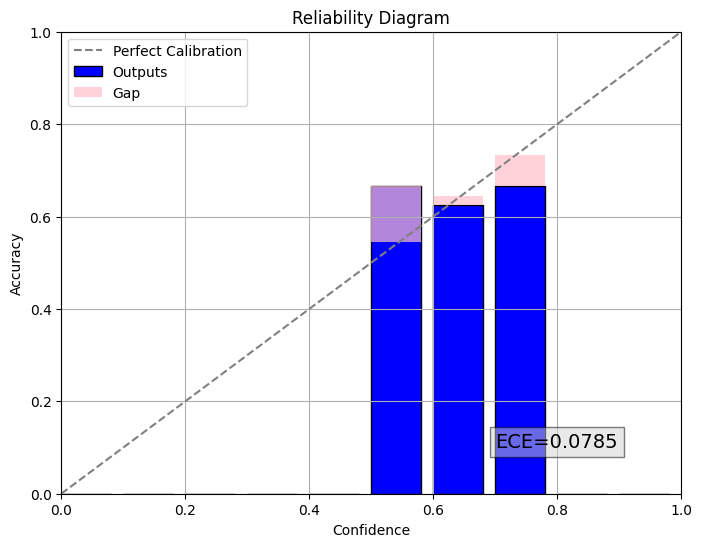

In [46]:
uq_trainer.writer.compute_confidence(uq_trainer.writer.confidence_list, uq_trainer.writer.is_correct_list)